In [1]:
import os
from random import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL.ImageColor import colormap

import image_processor
import model_builder

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split

from datetime import datetime

In [2]:
image_size = (32, 32)
input_size = (*image_size, 1)

In [3]:
df_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
            'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [4]:
df_train = image_processor.process_image_data_with_edges("data/Train", image_size, targets=df_names)

In [5]:
X = df_train.drop(columns=['target'])
y = df_train['target']

In [6]:
X_data = X.values.reshape(-1, *image_size, 1).astype('float32')
y_data = y.factorize()[0]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.05, stratify=y_data, random_state=42)

In [8]:
"""
model = model_builder.build_conv_pool_model(input_size, len(df_names))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=256,
                    callbacks=[early_stopping, tensorboard_callback],
                    validation_data=(X_val, y_val),
                    verbose=1)

for epoch, (val_loss, val_acc) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy']), start=1):
    print(f"Epoch {epoch}: val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}")

score = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {score[1] * 100:.2f}%")
"""

'\nmodel = model_builder.build_conv_pool_model(input_size, len(df_names))\n\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=5, restore_best_weights=True)\n\nlog_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")\ntensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)\n\nhistory = model.fit(X_train, y_train,\n                    epochs=50,\n                    batch_size=256,\n                    callbacks=[early_stopping, tensorboard_callback],\n                    validation_data=(X_val, y_val),\n                    verbose=1)\n\nfor epoch, (val_loss, val_acc) in enumerate(zip(history.history[\'val_loss\'], history.history[\'val_accuracy\']), start=1):\n    print(f"Epoch {epoch}: val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}")\n\nscore = model.evaluate(X_val, y_val, verbose=0)\nprint(f"Final Validation Accuracy: {score[1] * 100:.2f}%")\n'

In [9]:
test_df = image_processor.process_image_data_with_edges("data/TestData", image_size)

In [10]:
X_test = test_df.iloc[:, 1:]
X_test_prepared = X_test.values.reshape(-1, *image_size, 1).astype('float32')

In [11]:
from tensorflow.keras.models import load_model

model = load_model("models/model_final2")
pred = model.predict(X_test_prepared)

222/222 [==============================] - 1s 5ms/step


In [12]:
pred

array([[9.65996033e-11, 1.97424406e-13, 9.89097595e-01, ...,
        8.78065416e-12, 2.23097185e-09, 6.31305340e-07],
       [2.80922757e-10, 2.27921102e-11, 5.85539267e-13, ...,
        1.53933379e-05, 4.90033329e-08, 1.18080756e-07],
       [1.04416589e-15, 2.57086158e-10, 2.17866903e-13, ...,
        2.34633681e-08, 1.70545369e-10, 5.61249137e-11],
       ...,
       [1.29942794e-08, 9.87471222e-16, 1.10668620e-10, ...,
        2.42015270e-15, 2.72763767e-09, 2.64971642e-15],
       [8.66883039e-01, 4.18830010e-14, 1.07727022e-11, ...,
        5.96352234e-15, 2.65961949e-12, 7.56723406e-16],
       [5.45412853e-08, 2.01129096e-05, 1.42077425e-08, ...,
        7.44218141e-06, 4.81919096e-06, 2.28212433e-04]], dtype=float32)

In [13]:
predicted_classes = pred.argmax(axis=1)
len(predicted_classes)

7100

In [15]:
pd.DataFrame(pred[3086])

,0
0,2.254148e-07
1,5.362420e-06
2,2.292818e-07
3,2.087439e-05
4,1.155723e-02
...,...
57,1.073984e-06
58,3.844172e-04
59,4.469237e-04
60,3.380330e-06


In [16]:
predicted_labels = [df_names[i] for i in predicted_classes]

test_df['pred'] = predicted_classes + 1
test_df['pred_labels'] = predicted_labels

In [17]:
#model.save("models/model_final2")

In [18]:
filtered_df = test_df[test_df['target'] == 'Test0322.png']
filtered_df[['target', 'pred', 'pred_labels']]

,target,pred,pred_labels
1155,Test0322.png,40,d


In [ ]:
plt.imshow(X_test_prepared[2112], cmap='gray')

In [19]:
df_lead = test_df[['pred', 'target']].sort_values(by=['target'], ascending=True).reset_index(drop=True)

In [20]:
df_lead.columns = ['class', 'TestImage']

In [21]:
df_lead

,class,TestImage
0,19,Test0001.png
1,19,Test0002.png
2,45,Test0003.png
3,45,Test0004.png
4,45,Test0005.png
...,...,...
7095,23,Test7096.png
7096,11,Test7097.png
7097,11,Test7098.png
7098,13,Test7099.png


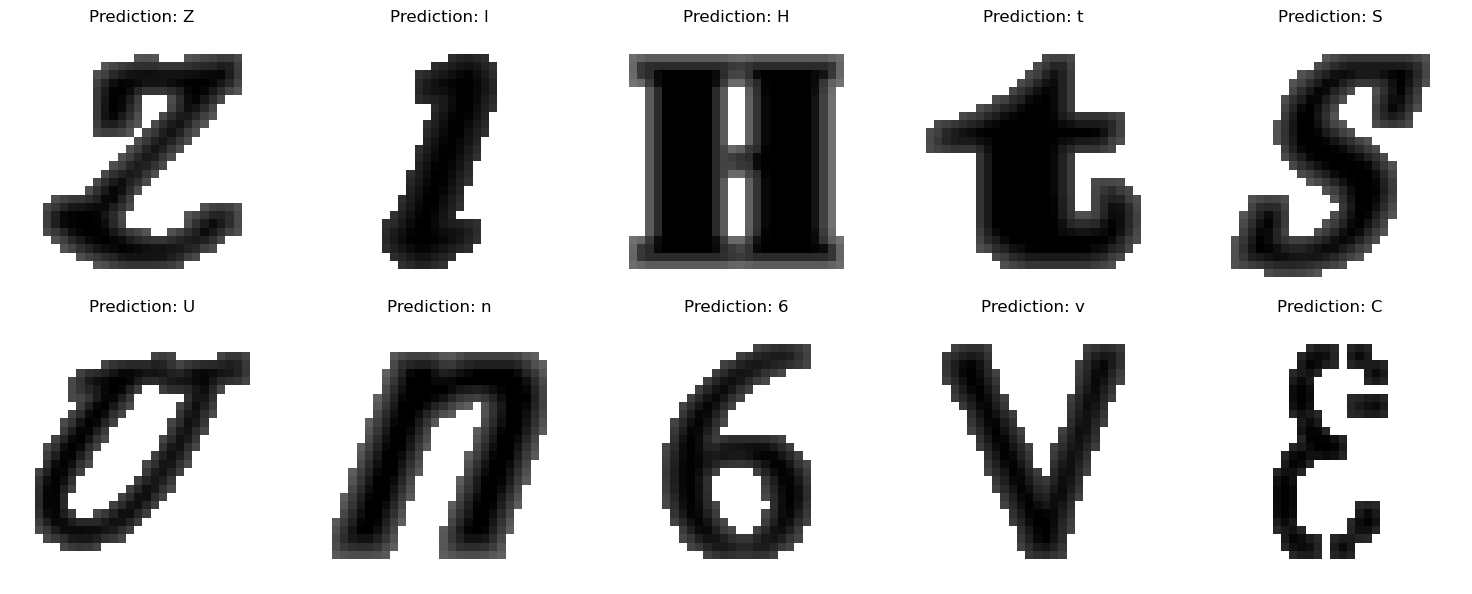

In [33]:
import matplotlib.pyplot as plt
import random

# Véletlenszerűen kiválasztunk 10 ID-t a DataFrame-ből
random_ids = random.sample(list(test_df.index), min(10, len(test_df)))

# Alábrák elrendezése: 2 sor, 5 oszlop
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2x5 rács, képek elrendezése

# Az ID-khoz tartozó képek kirajzolása a predikcióval
for ax, img_id in zip(axes.flatten(), random_ids):
    pred_label = test_df.loc[img_id, 'pred_labels']  # Predikció lekérdezése
    ax.imshow(X_test_prepared[img_id], cmap='gray')
    ax.set_title(f"Prediction: {pred_label}")
    ax.axis('off')  # Törli a tengelyeket

# Szorosan elrendezett ábrák megjelenítése
plt.tight_layout()
plt.show()